In [2]:
import importlib
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import scipy.stats as stats

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import analysis

importlib.reload(analysis)

<module 'analysis' from '/home/masse/work/CellPainting/analysis.py'>

# Introduction

This project was intended to understand how cell morphology changes across drug conditions using Cell Painting (CP). The analysis is performed at the well-level, in which the CP features are averaged across all cells within each well.

# Create the dataset

### Defining the data sources

The data for this analysis comes in three parts:

- an excel file that maps each drug code to the plate well row and column
- an excel file that maps the drug code to the drug name and concentration
- a list of directories, each including a .txt file with the well-averaged CP features, and (optional) the well-averaged phagocytosis data.

In [3]:
# excel file with the plate schema
# i.e. file linking plate locations to drug/concentration codes
plate_schema_fn = "data/Plate_setup_SchemaA_11Dx3x7conc.xlsx"

# excel file with drug information
# i.e. file drug/concentration codes with drugs names and concentration values
drug_info_fn = "data/Drug_conditions.xlsx"

# plate directories
# each plate directory contains a txt file with phagocytosis data, and a txt file with Cell Painting data
plate_directories = [
    "data/DATA PLATE 1",
    "data/DATA PLATE 2",
    "data/DATA PLATE 3",
]

### Create the h5ad structure

In the .h5ad structure  
    - .X matrix contains the normalized CP data  
    - obs contains the well location, drug inforation, and (optional) phagocytosis data  
    - var contains the CP feature names  


In [5]:
data = analysis.CreateData(
    plate_schema_fn,
    drug_info_fn,
    plate_directories,
)

data.create_anndata()

data/DATA PLATE 1
data/DATA PLATE 2
data/DATA PLATE 3


In [8]:
# view of the adata strcuture
data.adata

AnnData object with n_obs × n_vars = 923 × 5880
    obs: 'Plate', 'Drug', 'Concentration', 'All Cells - Number of Objects', 'Non border cells - Number of Objects', 'Non border cells - Total Spot Area - Mean per Well', 'Non border cells - Number of Spots - Mean per Well', 'Spots Substrate - Spot Area [px²] - Mean per Well', 'Spots Substrate - Relative Spot Intensity - Mean per Well', 'Phagocytosis per cell', 'All Cells - Number of Objects normalized', 'Non border cells - Number of Objects normalized', 'Non border cells - Total Spot Area - Mean per Well normalized', 'Non border cells - Number of Spots - Mean per Well normalized', 'Spots Substrate - Spot Area [px²] - Mean per Well normalized', 'Spots Substrate - Relative Spot Intensity - Mean per Well normalized', 'Phagocytosis per cell normalized'
    var: 'feature'
    layers: 'X_norm'

In [13]:
# Well observation data
data.adata.obs

Plate       Drug  Concentration  All Cells - Number of Objects  \
0    Plate 1   Riluzole           10.0                         2252.0   
1    Plate 1   Riluzole           10.0                         2421.0   
2    Plate 1   Riluzole           10.0                         2314.0   
3    Plate 1  Bisacodyl           10.0                         2631.0   
4    Plate 1  Bisacodyl           10.0                         2664.0   
..       ...        ...            ...                            ...   
918  Plate 3    c_cD_aB            0.0                         2376.0   
919  Plate 3    c_cD_aB            0.0                         2225.0   
920  Plate 3    c_cD_aB            0.0                         2273.0   
921  Plate 3    c_cD_aB            0.0                         2355.0   
922  Plate 3    c_cD_aB            0.0                         2085.0   

     Non border cells - Number of Objects  \
0                                  2067.0   
1                                  2226.0   
2                                  2140.0   
3                                  2378.0   
4                                  2465.0   
..                                    ...   
918                                2240.0   
919                                2109.0   
920                                2121.0   
921                                2159.0   
922                                1940.0   

     Non border cells - Total Spot Area - Mean per Well  \
0                                           695.517151    
1                                           725.987427    
2                                           723.778015    
3                                           757.116455    
4                                           731.096985    
..                                                 ...    
918                                         485.042419    
919                                         483.941681    
920                                         487.000000    
921                                         468.000000    
922                                         489.260315    

     Non border cells - Number of Spots - Mean per Well  \
0                                            11.887277    
1                                            13.280773    
2                                            12.677103    
3                                            13.841884    
4                                            13.652739    
..                                                 ...    
918                                           4.754018    
919                                           4.515884    
920                                           4.560585    
921                                           4.305234    
922                                           4.604639    

     Spots Substrate - Spot Area [px²] - Mean per Well  \
0                                            58.509380   
1                                            54.664547   
2                                            57.093330   
3                                            54.697502   
4                                            53.549473   
..                                                 ...   
918                                         102.027893   
919                                         107.164322   
920                                         106.784554   
921                                         108.704895   
922                                         106.253777   

     Spots Substrate - Relative Spot Intensity - Mean per Well  \
0                                             0.594058           
1                                             0.602326           
2                                             0.600240           
3                                             0.610978           
4                                             0.611548           
..                                                 ...           
918         

In [11]:
# Cell Painting feature names
data.adata.var

feature
0     Nuclei Selected - Intensity Nucleus Region Phe...
1     Nuclei Selected - Intensity Nucleus Region Phe...
2     Nuclei Selected - Intensity Nucleus Region Phe...
3     Nuclei Selected - Intensity Nucleus Region Phe...
4     Nuclei Selected - Intensity Nucleus Region Phe...
...                                                 ...
5875  Nuclei Selected - Membrane Region PhenoVue 641...
5876  Nuclei Selected - Membrane Region PhenoVue 641...
5877  Nuclei Selected - Membrane Region PhenoVue 641...
5878  Nuclei Selected - Membrane Region PhenoVue 641...
5879  Nuclei Selected - Membrane Region PhenoVue 641...

[5880 rows x 1 columns]

In [11]:
#target_name = "Phagocytosis per cell normalized"
#data.pls_regression(target_name)

# Data analysis

In [15]:
# load anndata into Analysis class
data = analysis.Analysis(data.adata)

### Plot dose-response curves

Visualize how the amount of phagocytosis (either normalized to the plate's DMSO condition, first set of panels, and unnormalized, second set of panels), varies across each drug an concentration.

"Number of Spots" is a proxy for the total amount of phagocytosed substrate in each well.  
"Number of Objects" is the number cells per well, and acts as a proxy for cell health.

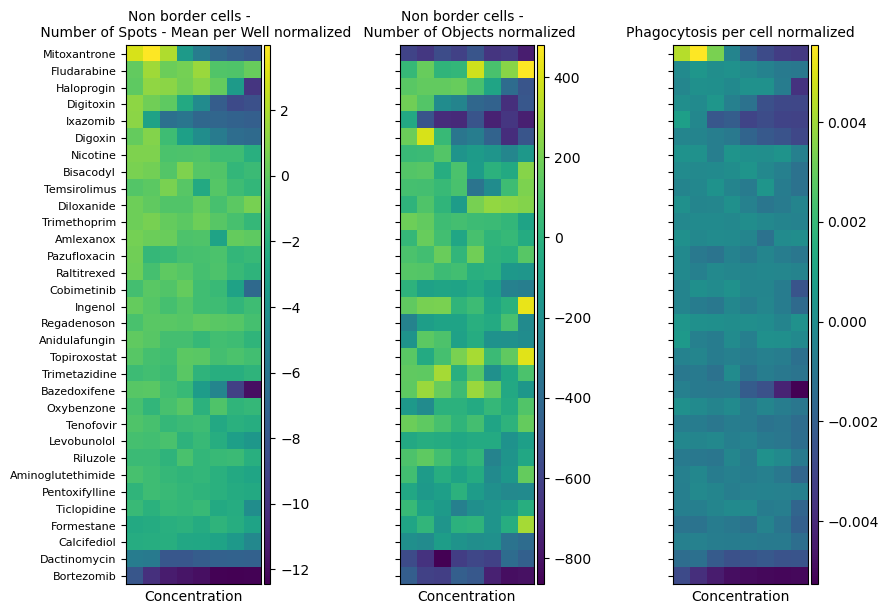

In [22]:
# normalize = True implies the response of c_aB_DM from the plate with associated drug is substrated from the response
idx_sort = data.plot_all_dose_responses(normalized=True)

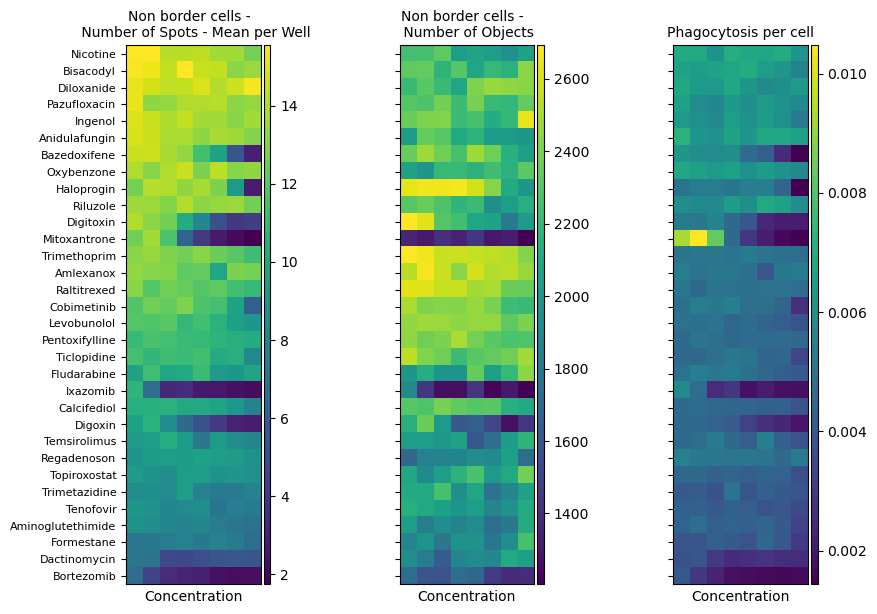

array([ 3,  1,  6,  4,  7,  2,  8,  5, 31,  0, 30, 18, 29, 27, 28, 25, 22,
       24, 21, 19, 16, 23, 20, 17, 15, 14, 13, 11, 10, 12, 26,  9])

In [23]:
data.plot_all_dose_responses(normalized=False)

## Features most correlated with phagocytosis

We measure the Pearson correlation between the mean phagocytosis in each well and the mean of each Cell Painting feature. We then list the top positively and negatively correlated features.

In [24]:
# phagocytosis key
key = "Non border cells - Number of Spots - Mean per Well"


n = data.adata.X.shape[1] # number of cell painting features
R = np.zeros(n)
for i in range(n):
    R[i], _ = stats.pearsonr(data.adata.X[:, i], data.adata.obs[key].values)

idx = np.argsort(R)

print(f"Features most negatively correlated with {key}")
print()
for i in idx[:20]:
    print(f"{data.adata.var.feature.values[i][18:]}, R = {R[i]:1.3f}")
print()
print(f"Features most positively correlated with {key}")
print()
for i in idx[-20:]:
    print(f"{data.adata.var.feature.values[i][18:]}, R = {R[i]:1.3f}")

Features most negatively correlated with Non border cells - Number of Spots - Mean per Well

Ring Region PhenoVue Fluor 555 Symmetry 05 SER-Dark - Mean per Well, R = -0.552
Ring Region PhenoVue Fluor 555 Symmetry 05 SER-Valley - Mean per Well, R = -0.551
Ring Region PhenoVue Fluor 555 Symmetry 04 SER-Hole - Mean per Well, R = -0.551
Ring Region PhenoVue Fluor 555 Symmetry 15 SER-Dark - Mean per Well, R = -0.549
Ring Region PhenoVue Fluor 555 Symmetry 14 SER-Hole - Mean per Well, R = -0.549
Ring Region PhenoVue Fluor 555 Symmetry 03 SER-Valley - Mean per Well, R = -0.548
Ring Region PhenoVue Fluor 555 Symmetry 15 SER-Valley - Mean per Well, R = -0.548
Ring Region PhenoVue Fluor 555 Symmetry 03 SER-Dark - Mean per Well, R = -0.548
Ring Region PhenoVue Fluor 555 Symmetry 05 SER-Hole - Mean per Well, R = -0.547
Ring Region PhenoVue Fluor 555 Symmetry 15 SER-Hole - Mean per Well, R = -0.546
Ring Region PhenoVue Fluor 555 Symmetry 13 SER-Dark - Mean per Well, R = -0.546
Ring Region PhenoVue 

To get a sense of which features appears among the top positively and negatively correlated features, we count how often different terms
appear in the list of the top features.

We categorize features into terms related to size and symmetry (e.g. radial mean, length, etc), dye wavelength (e.g. 488, 512), cell region (e.g. membrane, cytoplasm, etc), and geometric descriptor (e.g. dark, hole, edge, valley, etc.).

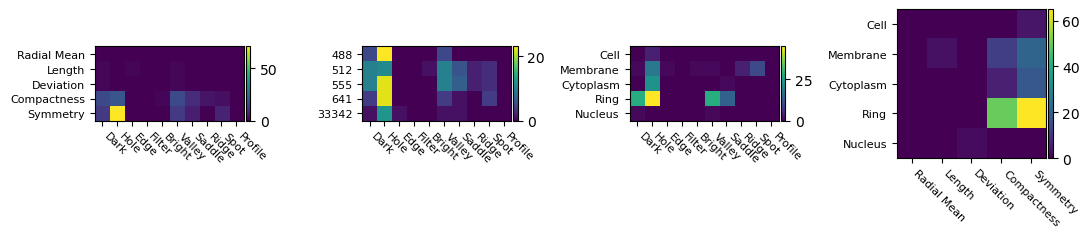

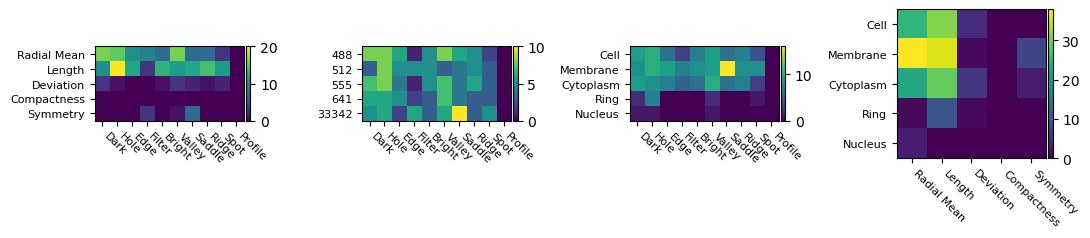

In [19]:

N = 250

# negatively correlated
features = [data.adata.var.feature.values[i] for i in idx[:N]]
data.plot_feature_counts(features)

# positively correlated
features = [data.adata.var.feature.values[i] for i in idx[-N:]]
data.plot_feature_counts(features)

Same analysis as above, but using the normalized phagocytosis feature

In [20]:

key = "Non border cells - Number of Spots - Mean per Well normalized"

n = data.adata.X.shape[1]
R = np.zeros(n)
for i in range(n):
    R[i], _ = stats.pearsonr(data.adata.X[:, i], data.adata.obs[key].values)
    

idx = np.argsort(R)

print(f"Features most negatively correlated with {key}")
for i in idx[:20]:
    print(f"{data.adata.var.feature.values[i][18:]}, R = {R[i]:1.3f}")
print()
print(f"Features most positively correlated with {key}")
for i in idx[-20:]:
    print(f"{data.adata.var.feature.values[i][18:]}, R = {R[i]:1.3f}")


Features most negatively correlated with Non border cells - Number of Spots - Mean per Well normalized
Ring Region PhenoVue Fluor 555 Symmetry 05 SER-Hole - Mean per Well, R = -0.630
Ring Region PhenoVue Fluor 555 Symmetry 05 SER-Dark - Mean per Well, R = -0.629
Ring Region PhenoVue Fluor 555 Symmetry 05 SER-Valley - Mean per Well, R = -0.629
Ring Region PhenoVue Fluor 555 Symmetry 15 SER-Hole - Mean per Well, R = -0.628
Ring Region PhenoVue 512 Nucleic acid stain Symmetry 05 SER-Dark - Mean per Well, R = -0.628
Ring Region PhenoVue Fluor 555 Symmetry 04 SER-Hole - Mean per Well, R = -0.627
Ring Region PhenoVue Fluor 555 Symmetry 03 SER-Valley - Mean per Well, R = -0.626
Ring Region PhenoVue 512 Nucleic acid stain Symmetry 05 SER-Hole - Mean per Well, R = -0.625
Ring Region PhenoVue 512 Nucleic acid stain Symmetry 03 SER-Valley - Mean per Well, R = -0.625
Ring Region PhenoVue 512 Nucleic acid stain Symmetry 05 SER-Valley - Mean per Well, R = -0.625
Ring Region PhenoVue 512 Nucleic acid

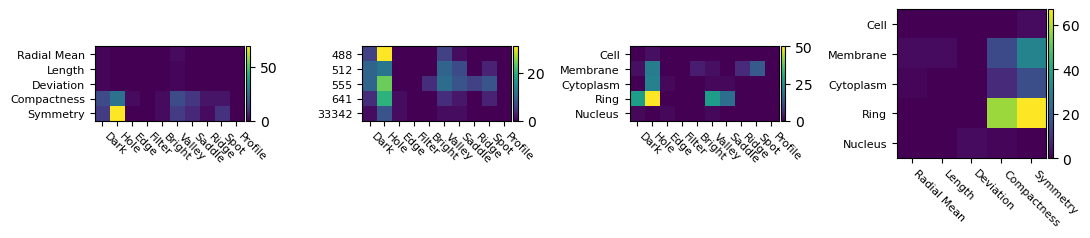

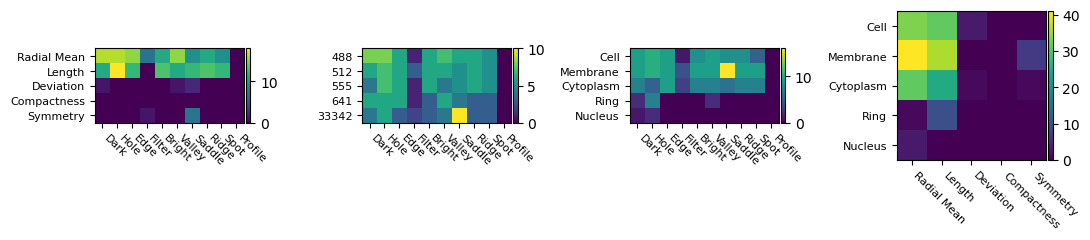

In [21]:
# visualizing how often each feature name appears in the top N=250 most positively and negatively correlated features
N = 250

# negatively correlated
features = [data.adata.var.feature.values[i] for i in idx[:N]]
data.plot_feature_counts(features)

# positively correlated
features = [data.adata.var.feature.values[i] for i in idx[-N:]]
data.plot_feature_counts(features)

## Individual dose-response curves

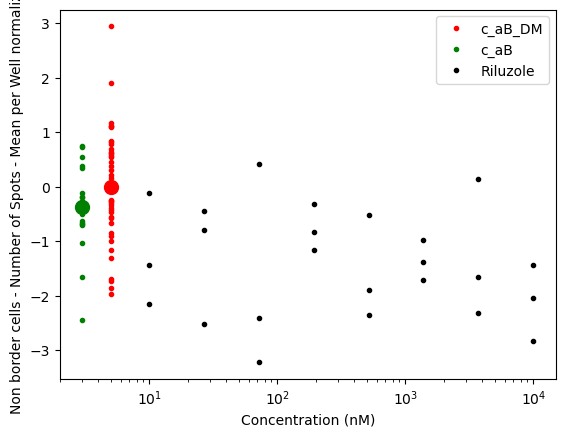

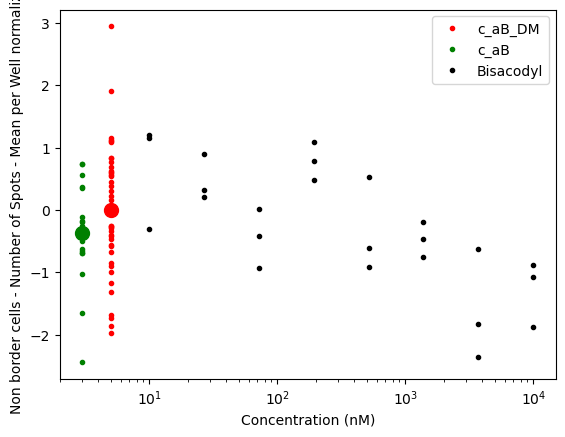

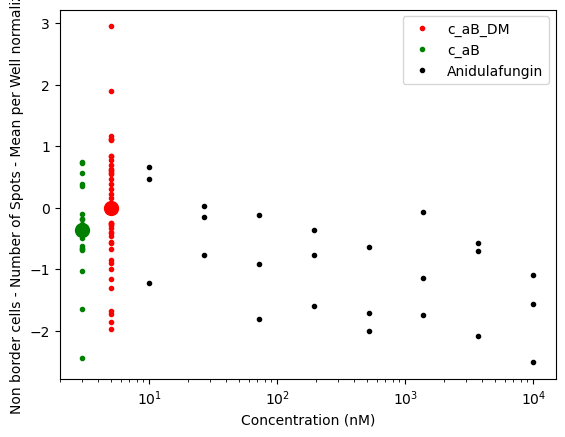

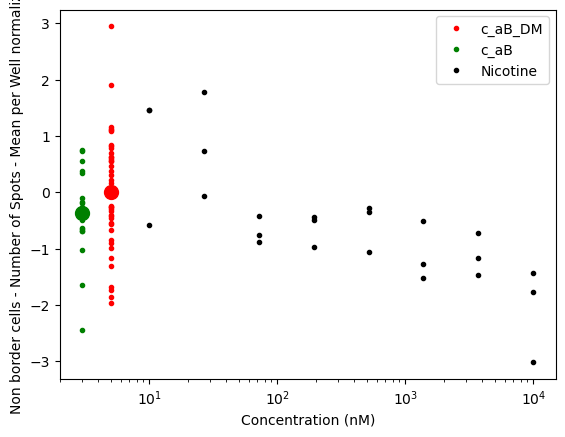

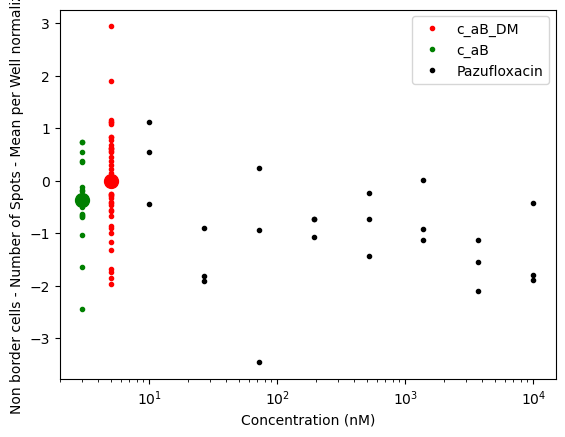

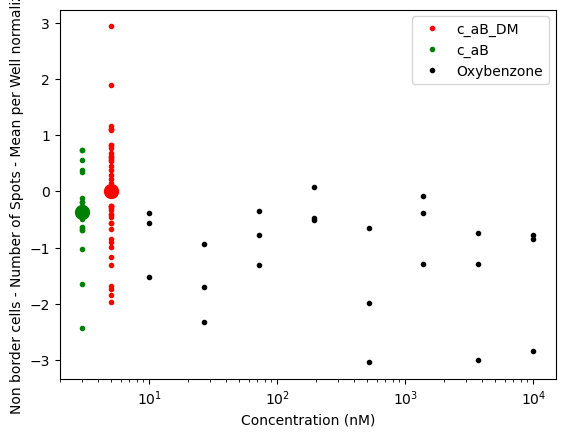

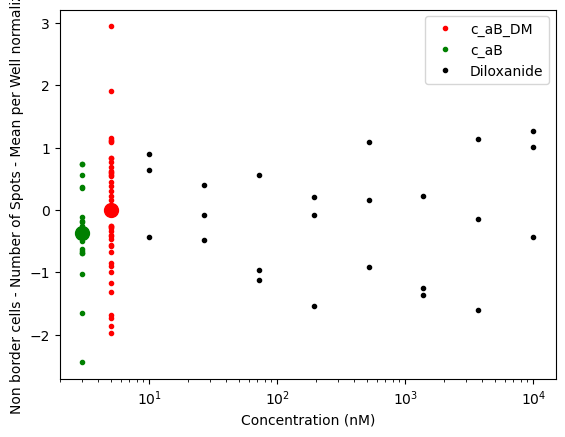

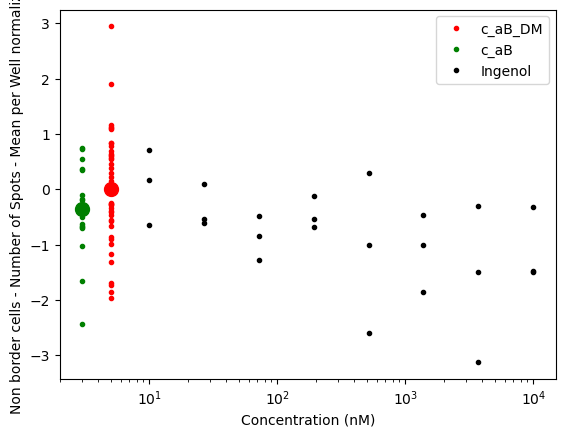

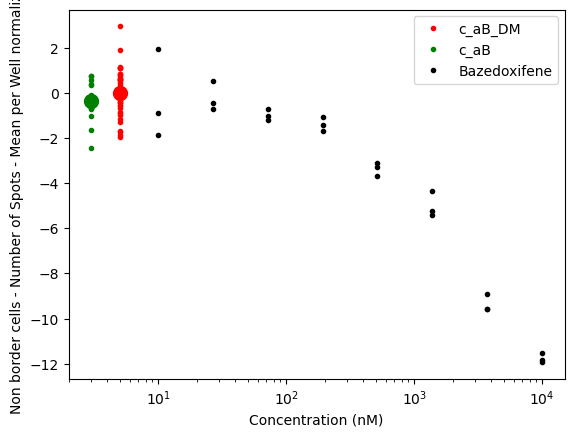

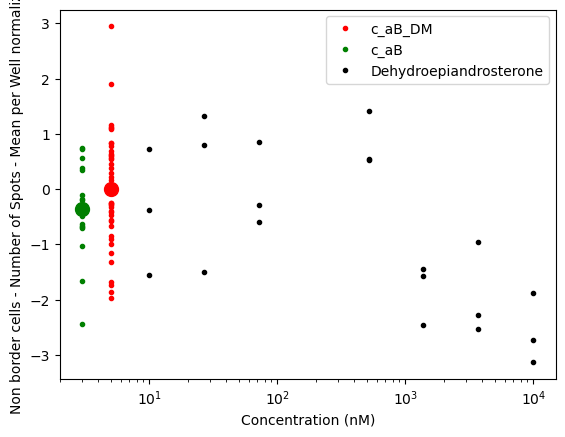

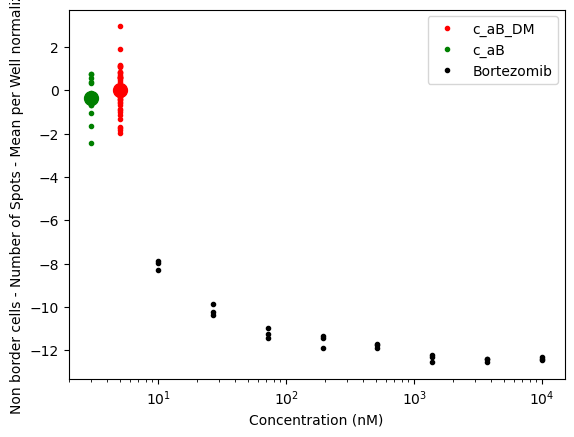

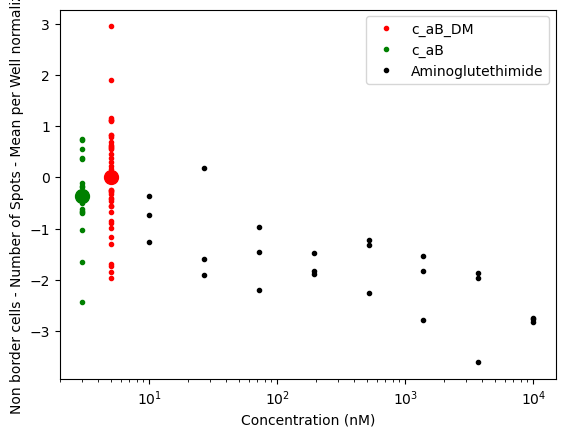

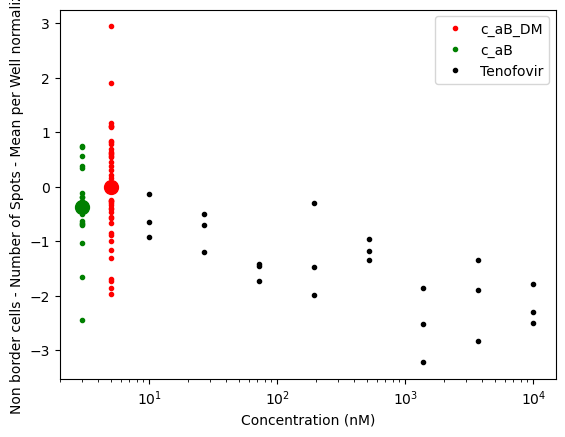

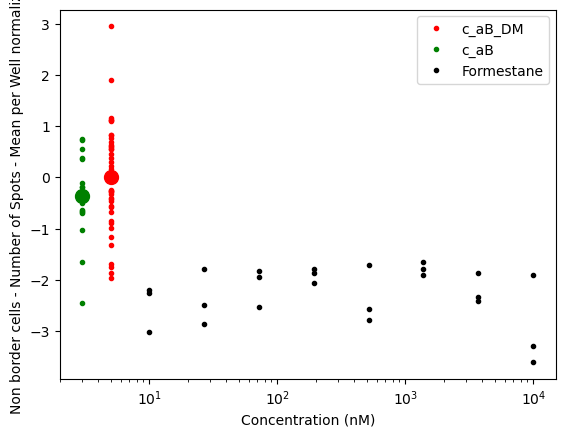

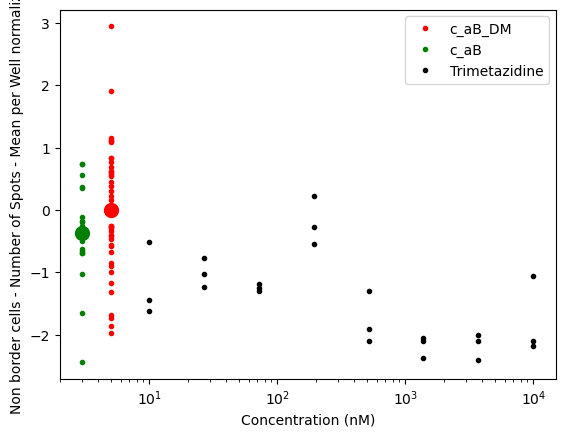

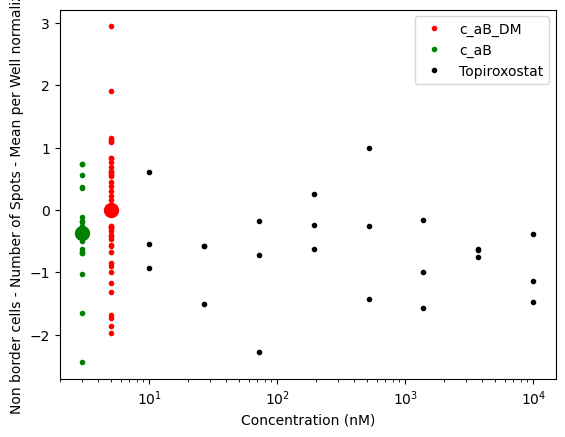

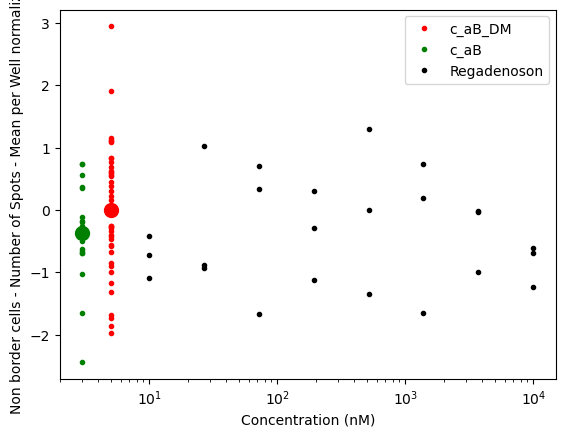

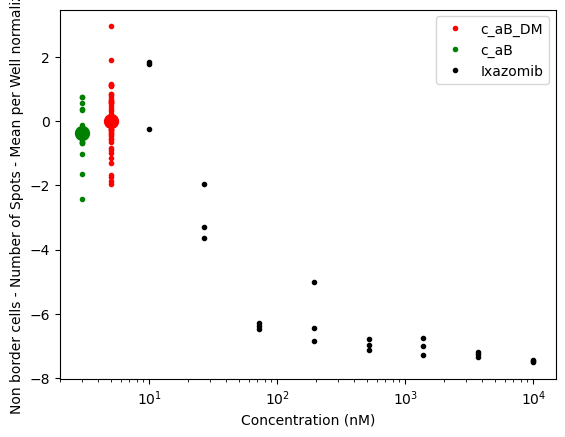

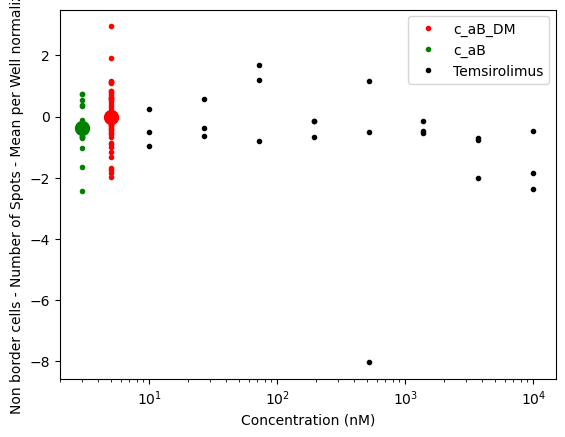

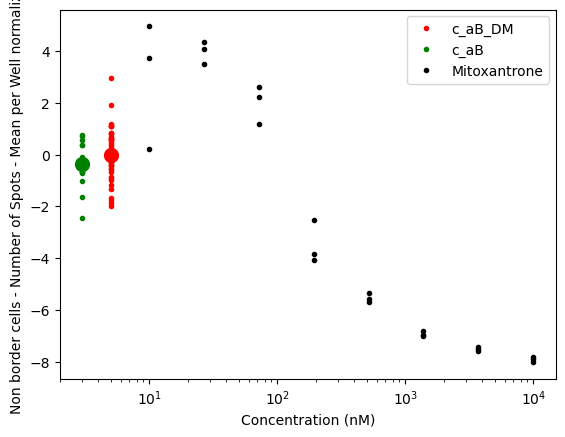

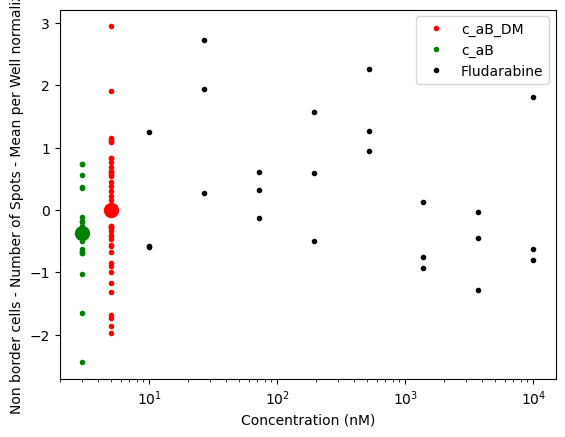

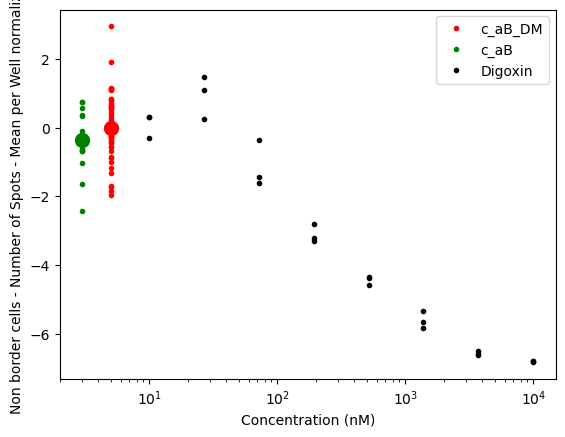

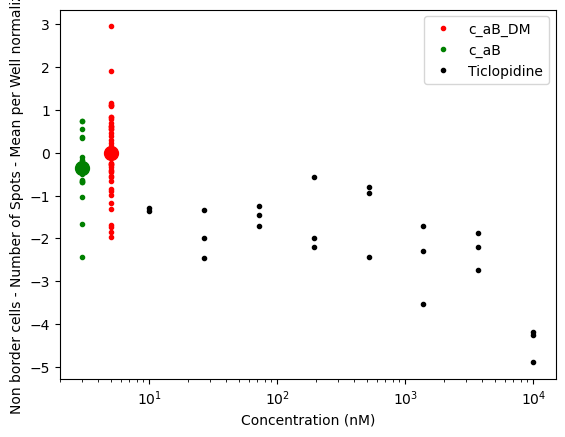

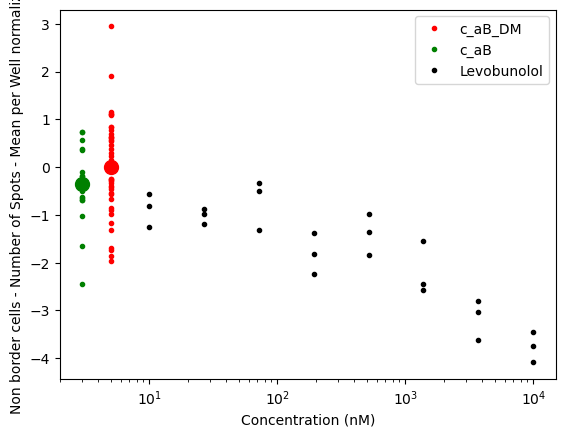

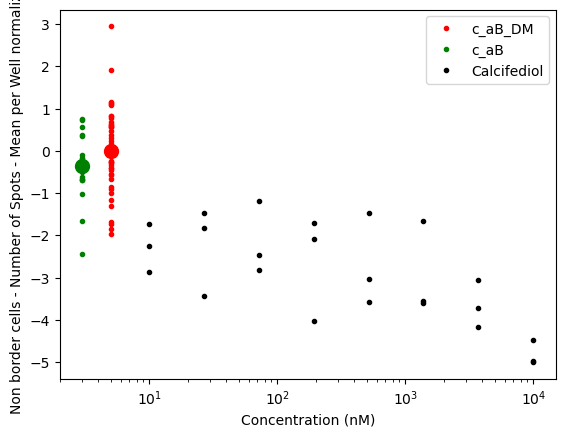

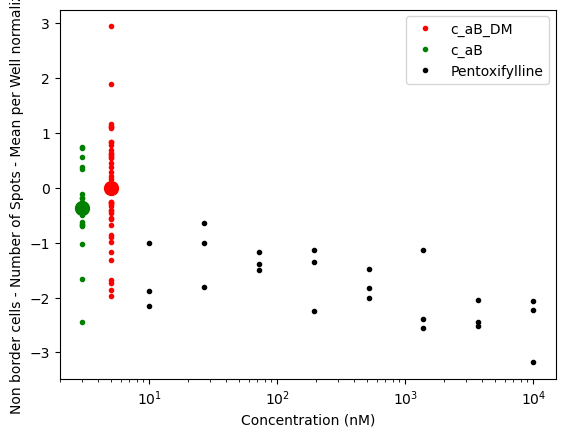

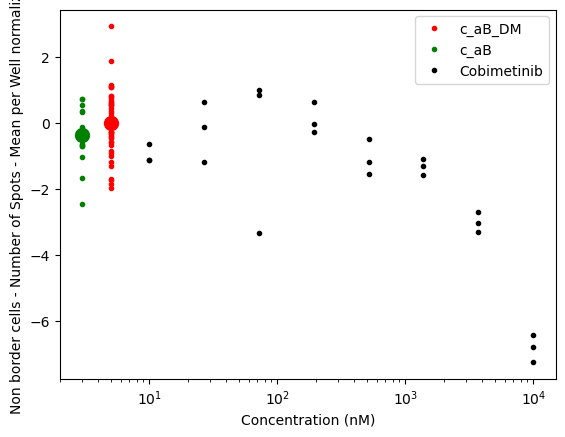

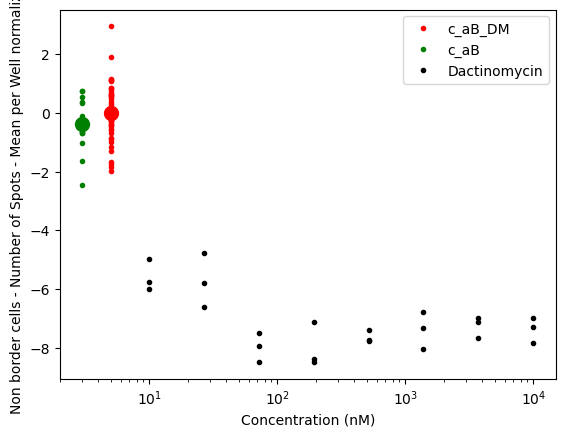

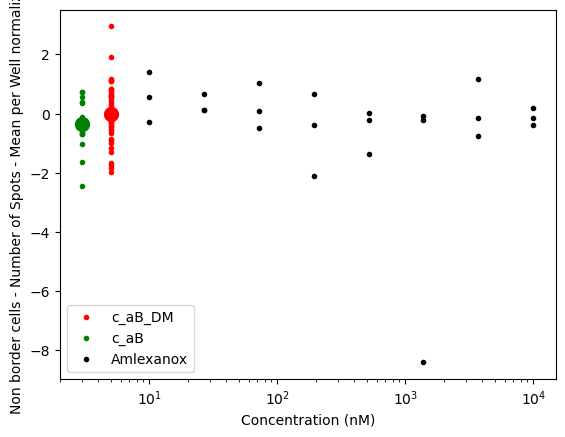

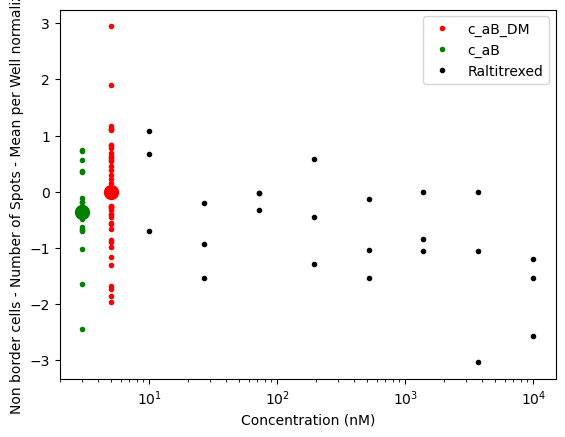

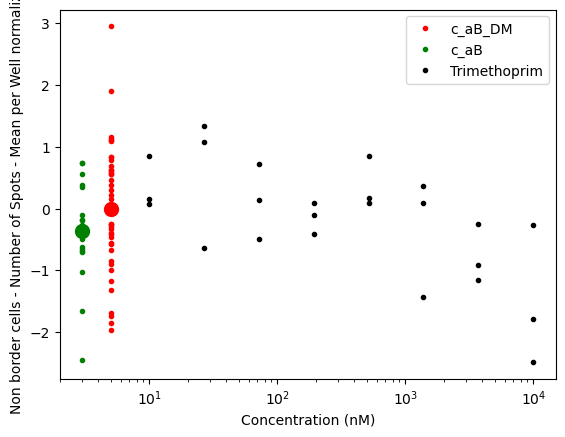

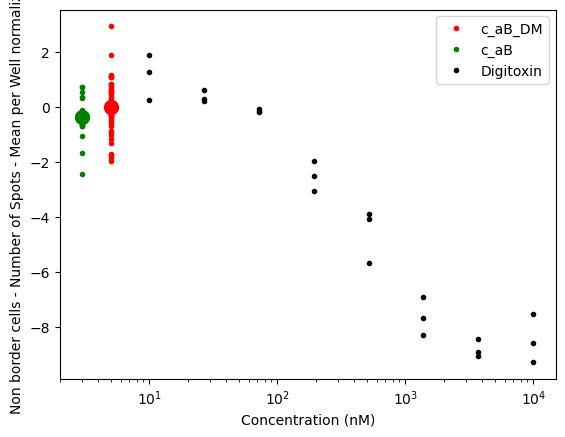

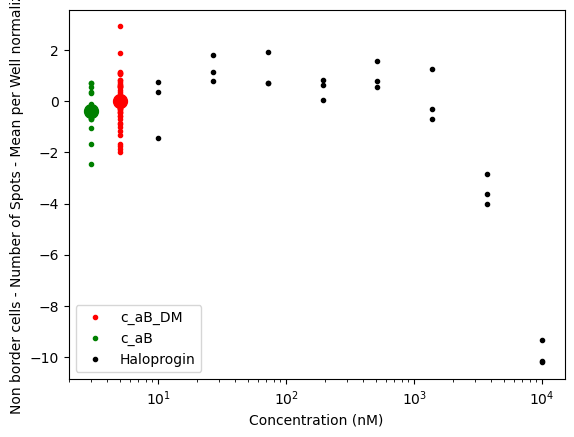

In [19]:
# phagocytosis dose-response curves
key = "Non border cells - Number of Spots - Mean per Well normalized"
drugs = data.adata.obs.Drug.unique()
for d in drugs:
    try:
        if not d.startswith("c"): # don't plot controls
            data.plot_dose_response(d, k=key)
    except:
        continue

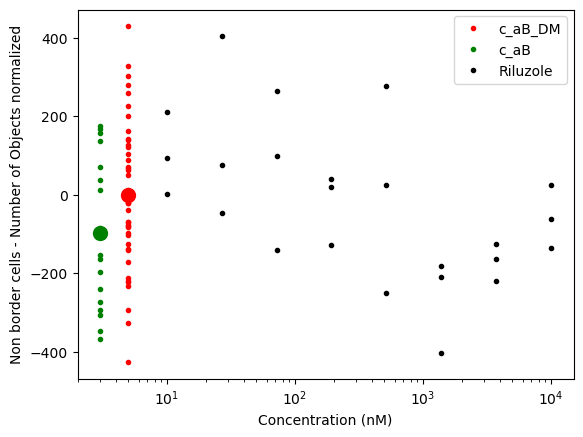

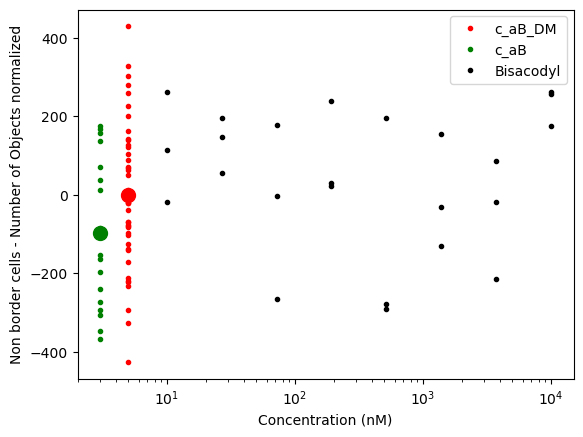

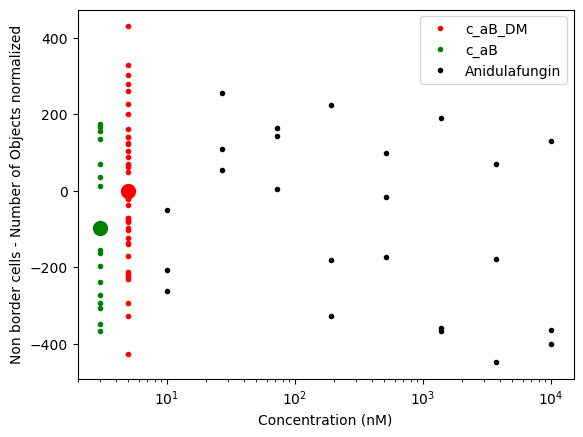

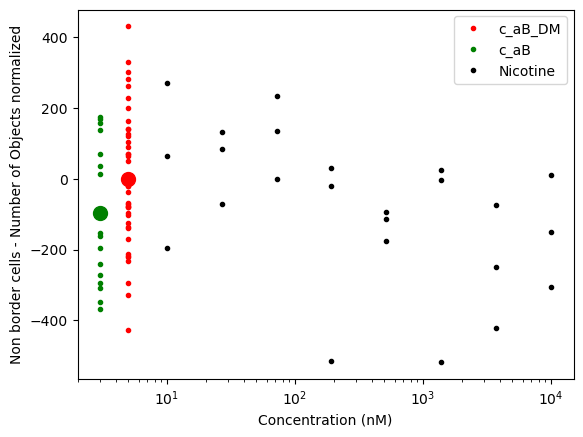

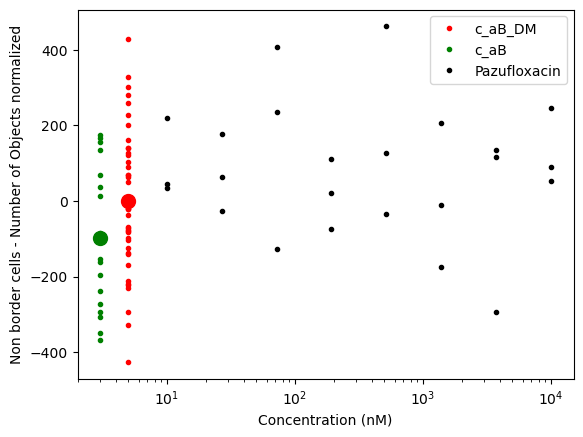

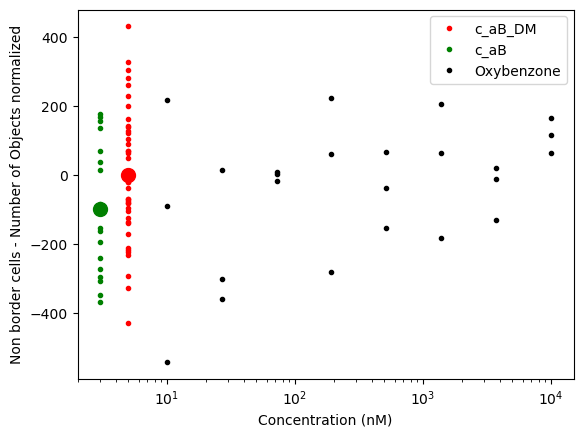

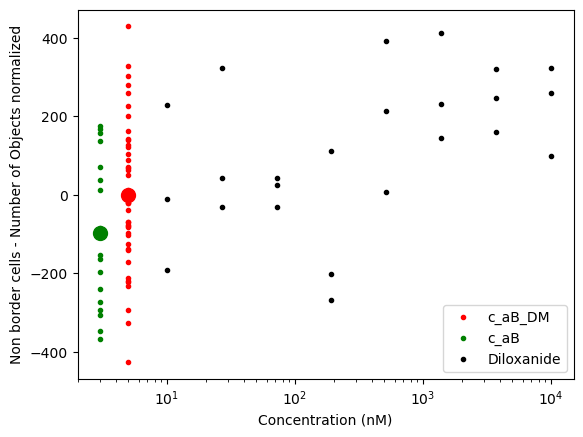

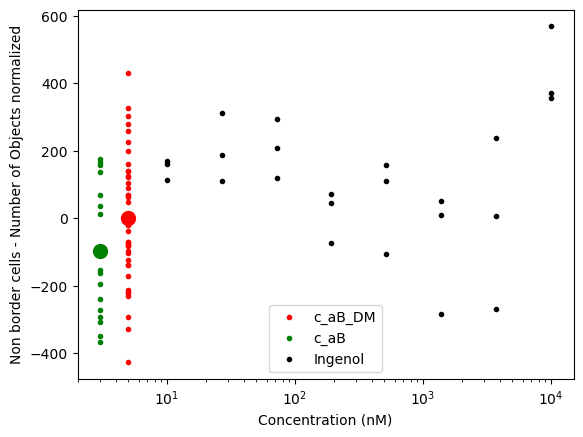

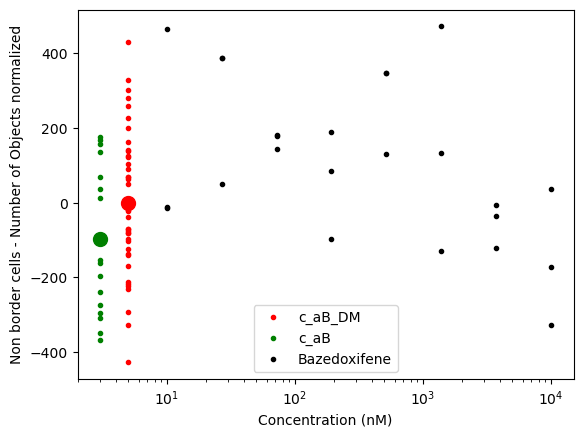

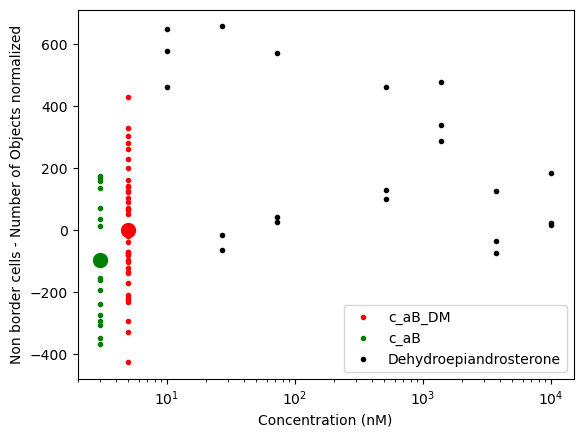

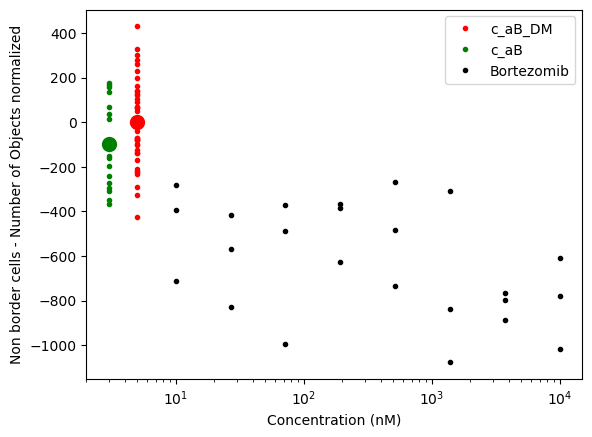

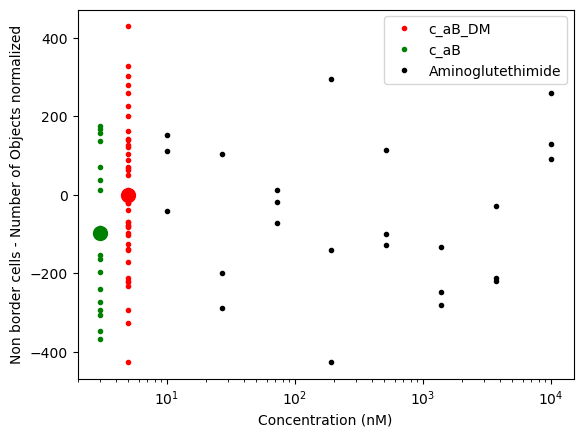

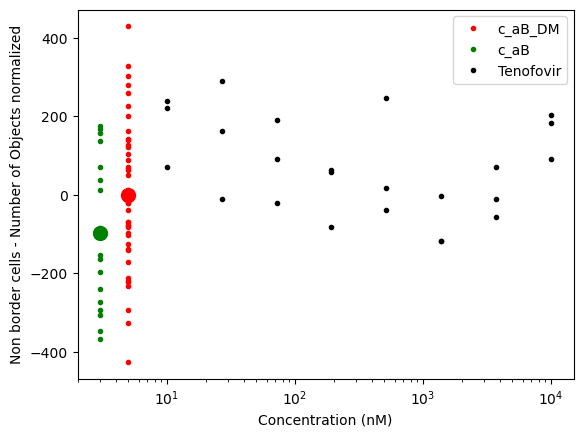

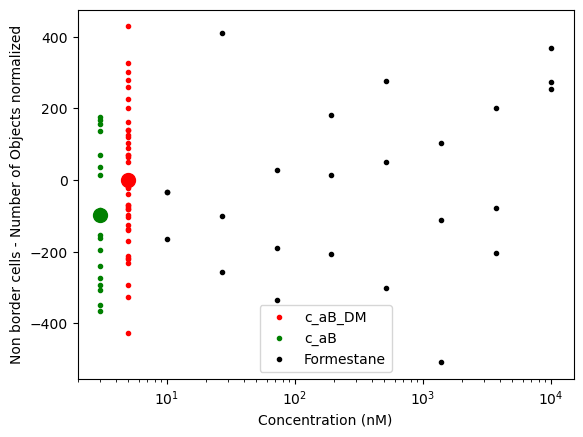

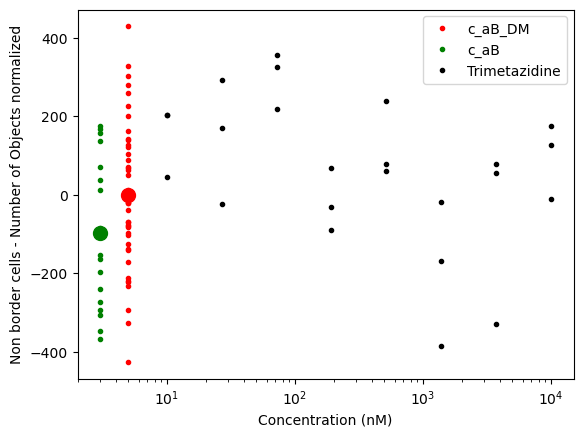

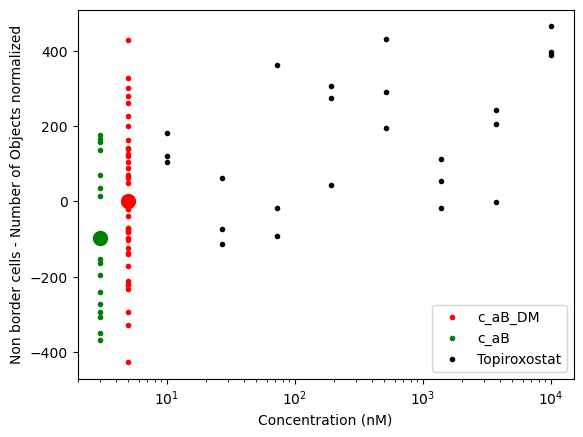

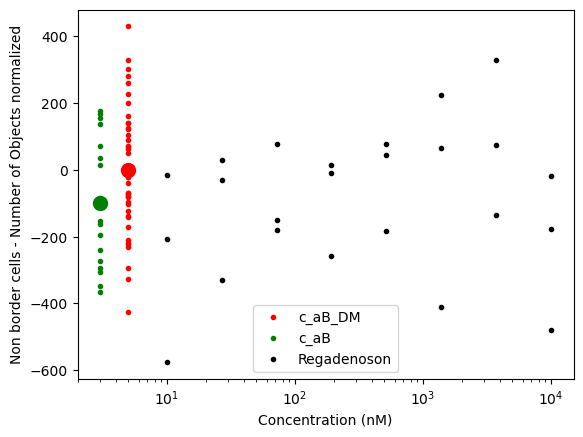

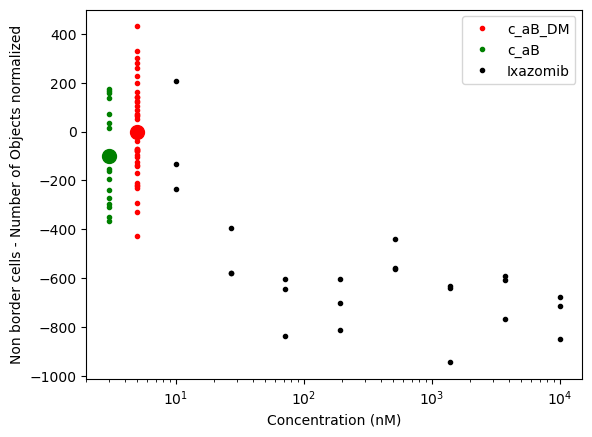

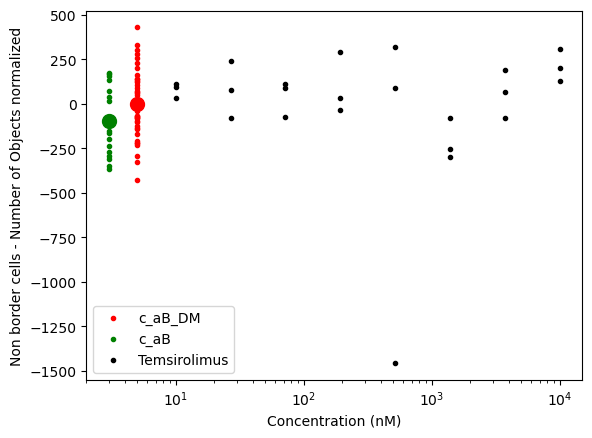

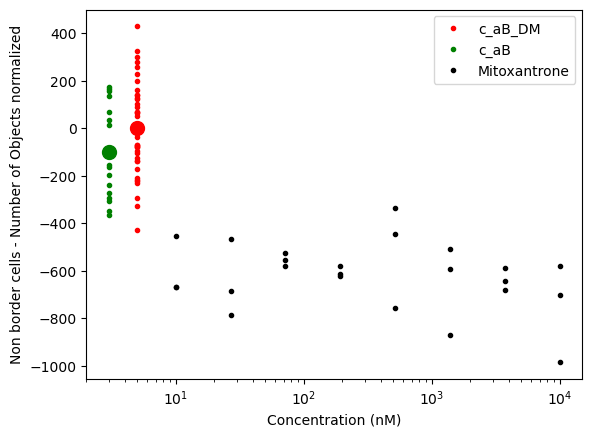

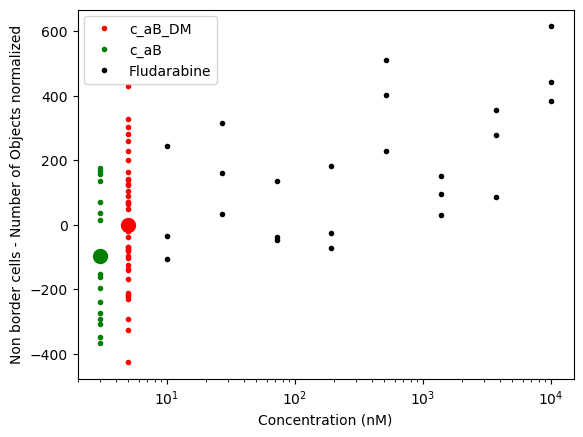

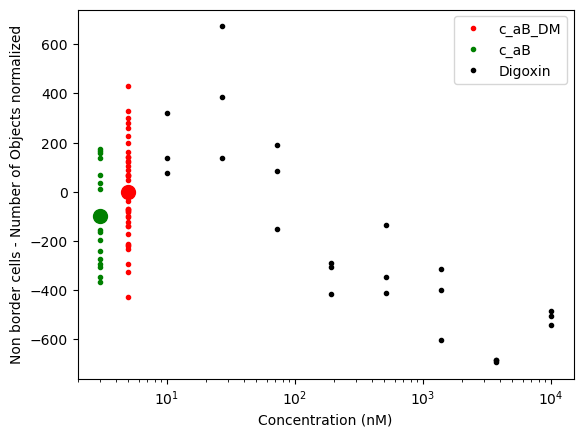

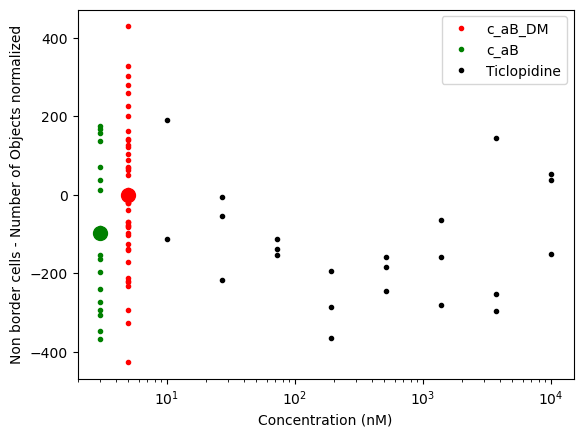

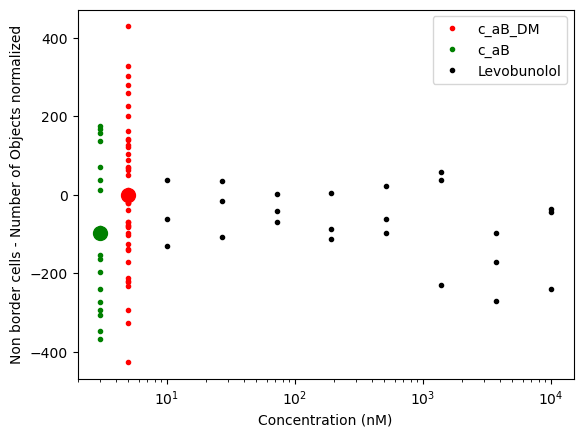

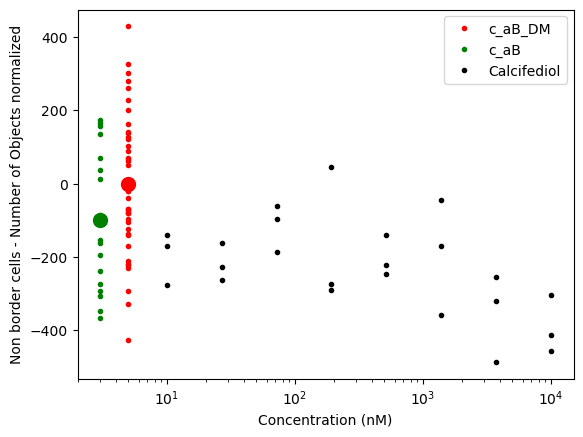

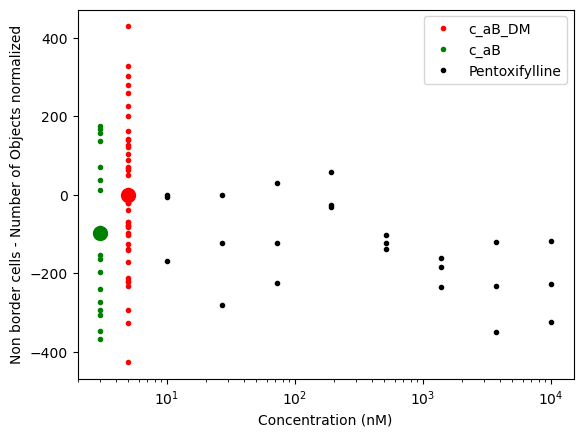

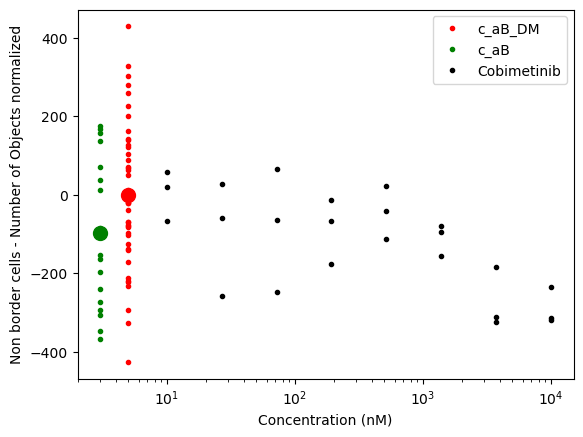

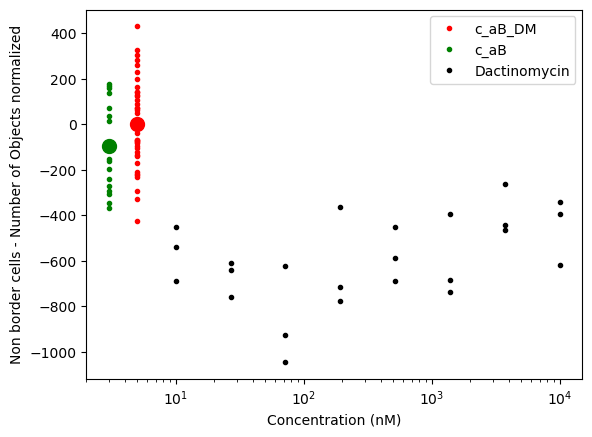

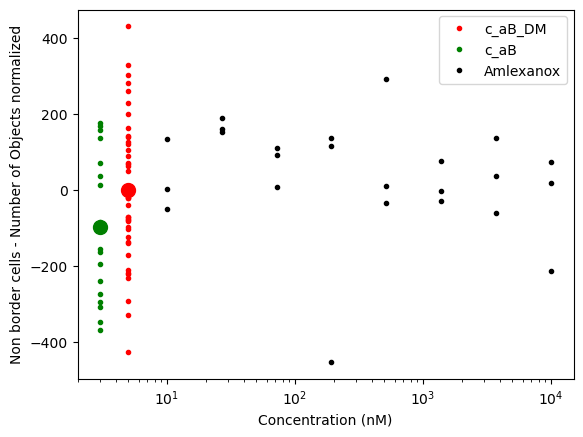

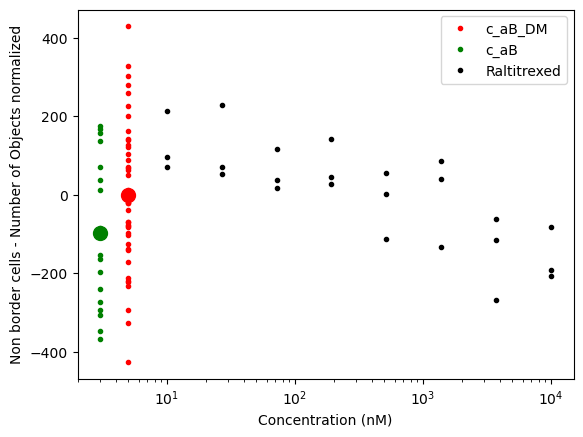

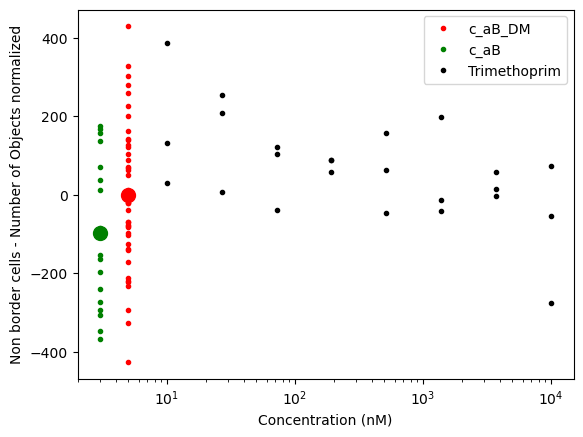

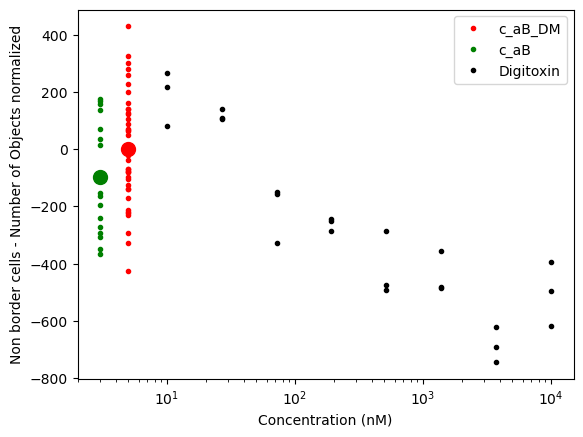

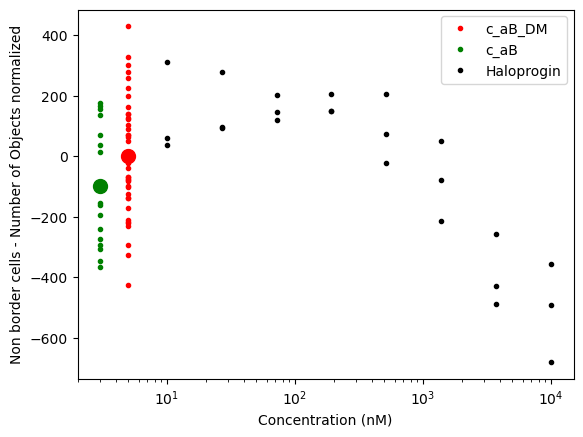

In [20]:
# number of objects (i.e. cells) dose-response curves
key = "Non border cells - Number of Objects normalized"

drugs = data.adata.obs.Drug.unique()
for d in drugs:
    try:
        if not d.startswith("c"): # don't plot controls
            data.plot_dose_response(d, k=key)
    except:
        continue

## PCA and UMAP plots

We visualize the distribution of Cell Painting data across drug conditions using PCA and UMAP analysis. We are especially intered in Mitoxantrone, which shows the strongest increase in phagocytosis in this preliminary dataset.

We find that Mitoxantrone does not form a separate cluster. In other worse, there is no clear morphological difference between the effect
of Mitoxantrone (at effective doses) and the effect of other drugs.

In [25]:
adata = data.adata

sc.pp.pca(adata, layer="X_norm", n_comps=30)
sc.pp.neighbors(adata, n_neighbors=15)
sc.tl.umap(adata)

/home/masse/miniconda3/envs/scanpy/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
adata.obs["Mitoxantrone"] = adata.obs.Drug == "Mitoxantrone"

In [27]:
sc.tl.leiden(adata, resolution=0.05)

/tmp/ipykernel_1277734/932759822.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.05)


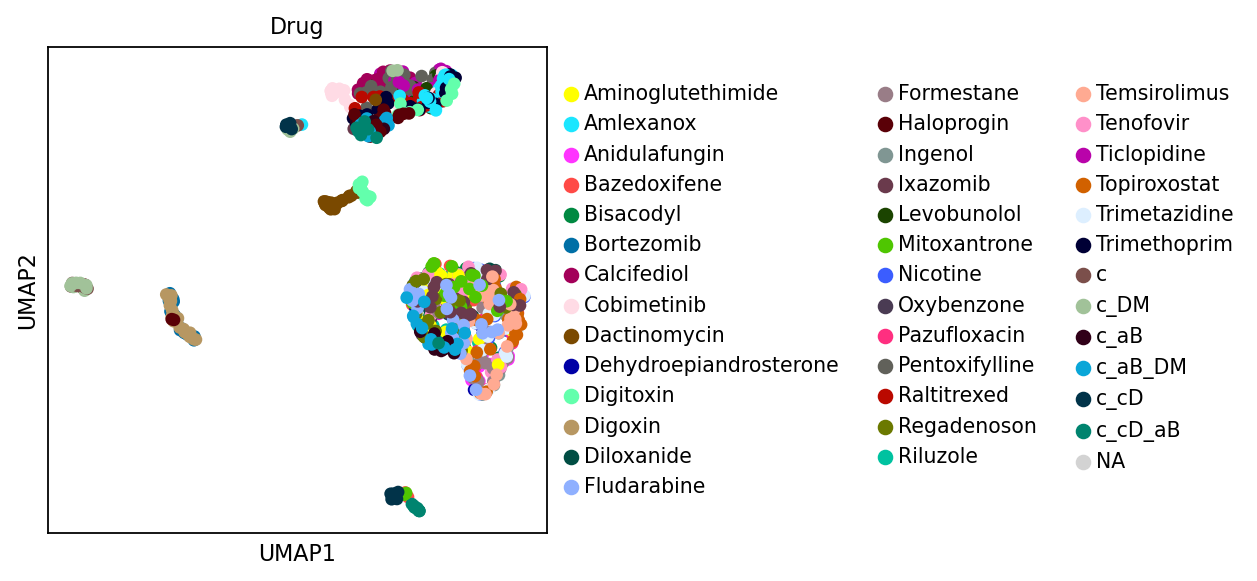

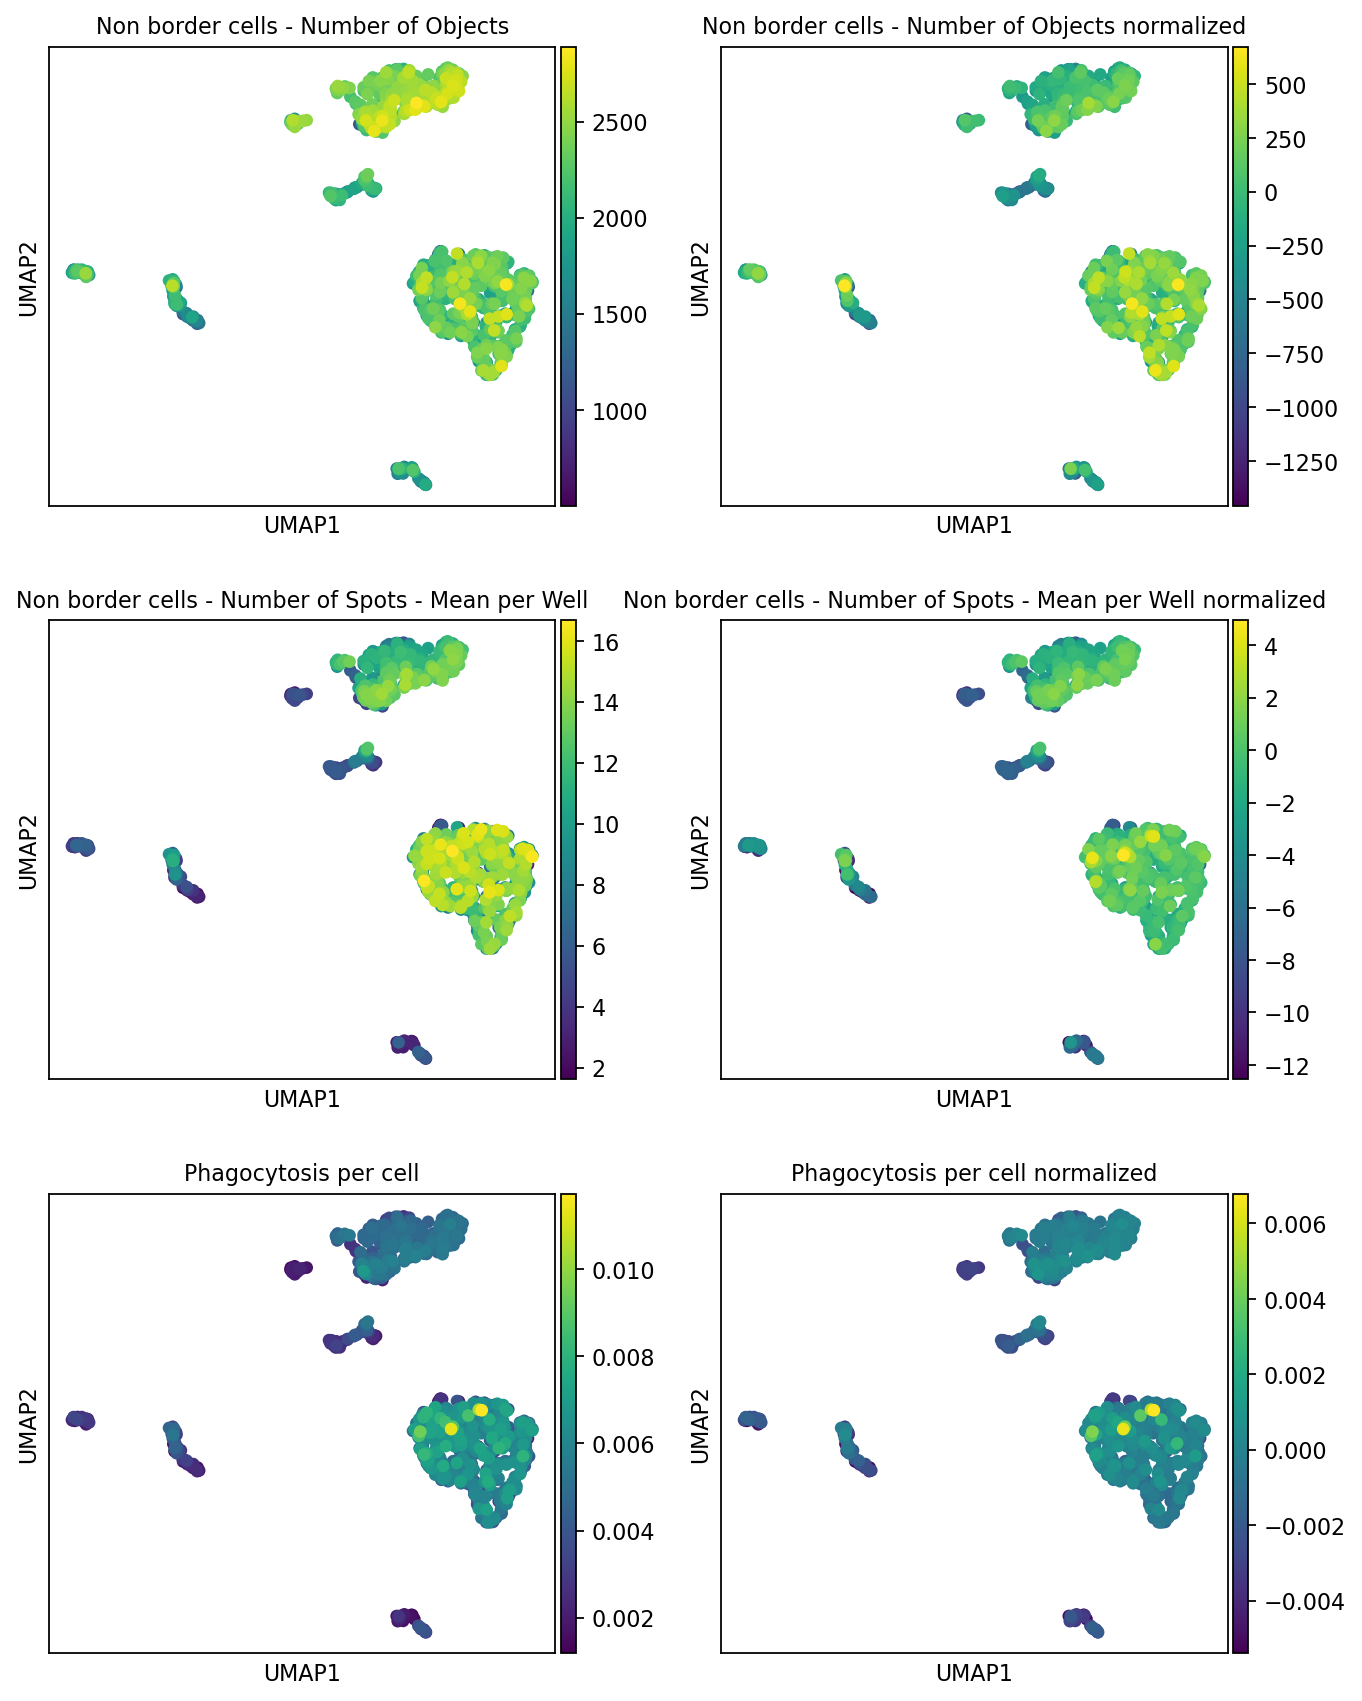

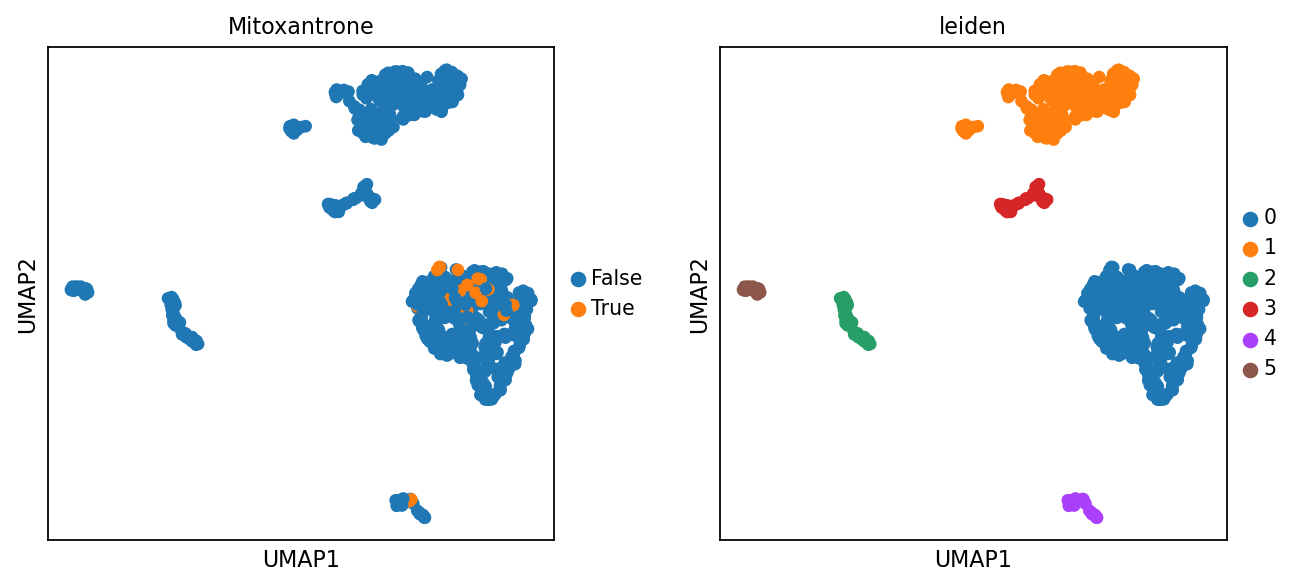

In [28]:

sc.set_figure_params(figsize=(1.5*3., 1.5*1.5))
sc.set_figure_params(fontsize=10)
adata.obs["Mitoxantrone"] = adata.obs.Drug == "Mitoxantrone"
sc.pl.umap(adata, color=["Drug"], ncols=2)


sc.set_figure_params(figsize=(3., 1.))
sc.set_figure_params(fontsize=10)
sc.pl.umap(adata, color=[
    "Non border cells - Number of Objects", 
    "Non border cells - Number of Objects normalized",
    "Non border cells - Number of Spots - Mean per Well", 
    "Non border cells - Number of Spots - Mean per Well normalized",
    "Phagocytosis per cell",
    "Phagocytosis per cell normalized",
    
], ncols=2)

sc.pl.umap(adata, color=[
    "Mitoxantrone",  "leiden",
], ncols=3)

## Scatter plots of phagocytosis (number of spots) and cell health (number of objects)

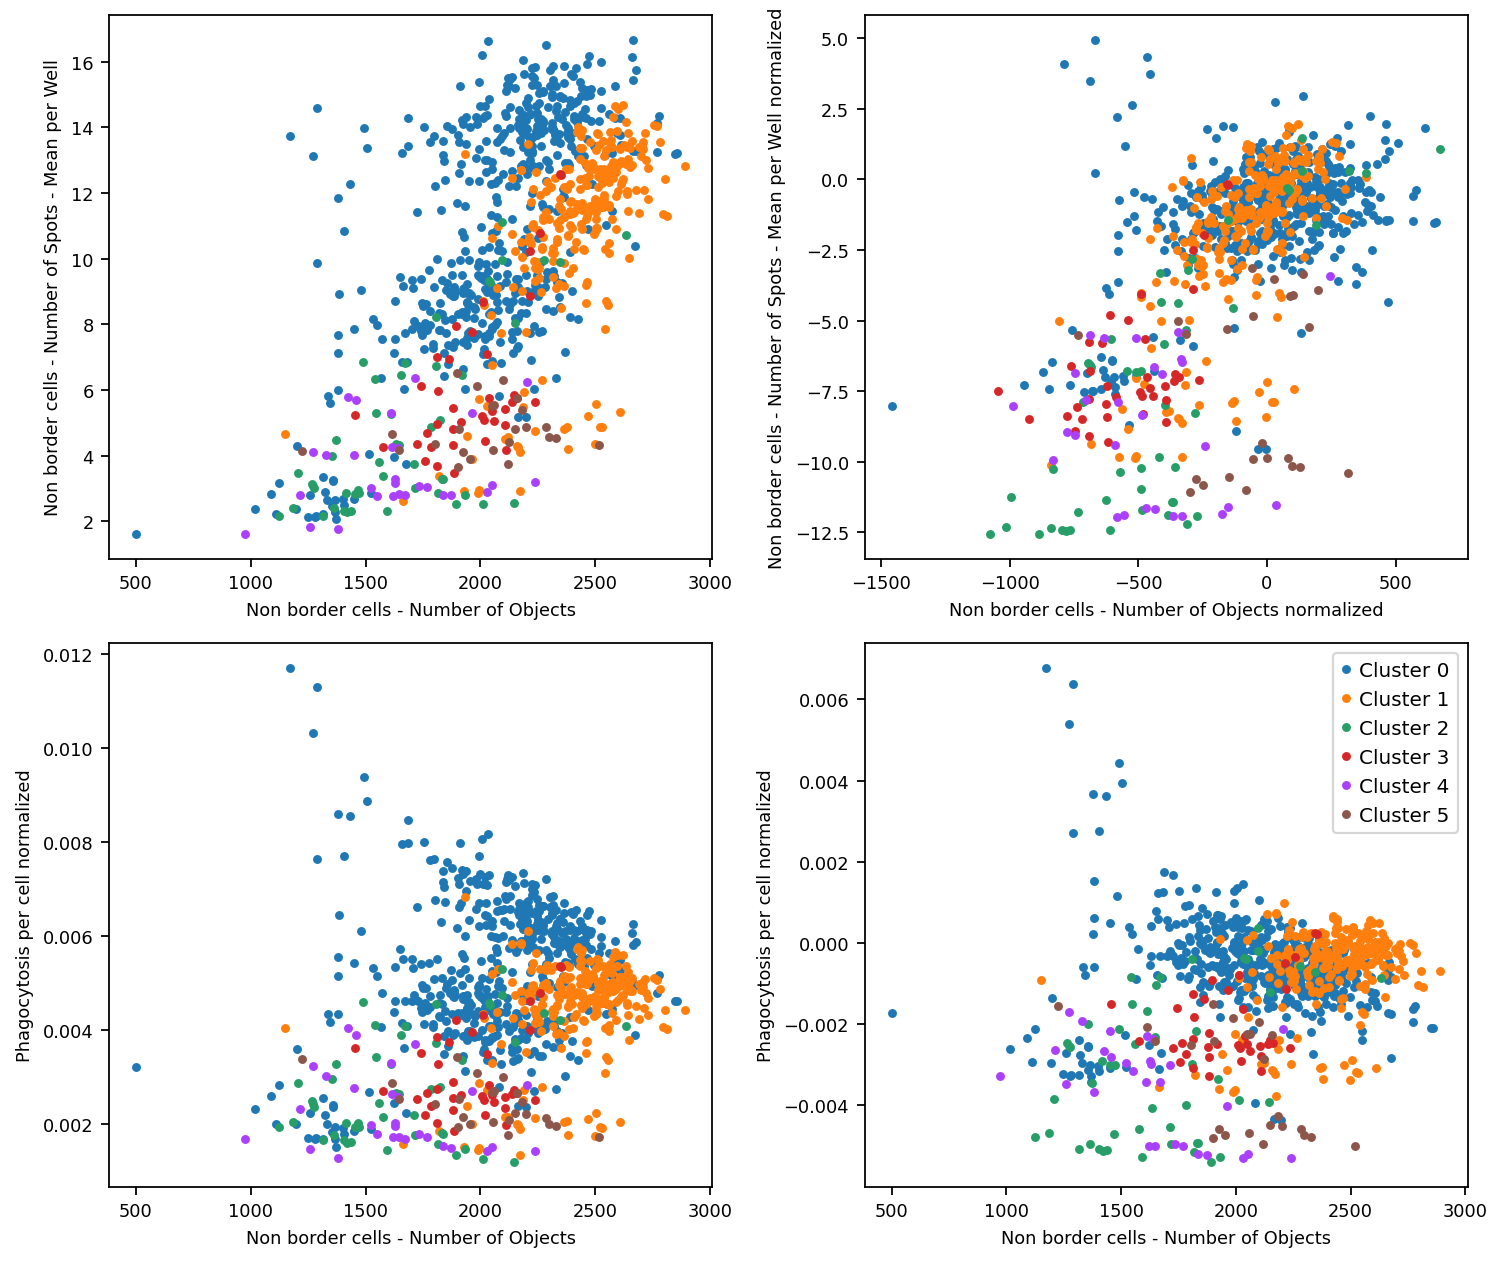

In [31]:
f, ax = plt.subplots(2, 2, figsize=(9.5, 8))
fs = 8

for n in range(6):
    idx = adata.obs.leiden == str(n)   
    ax[0, 0].plot(
        data.adata.obs["Non border cells - Number of Objects"].values[idx], 
        data.adata.obs["Non border cells - Number of Spots - Mean per Well"].values[idx], 
        '.',
        label = f"Cluster {n}",
    )
    ax[0, 0].set_xlabel("Non border cells - Number of Objects", fontsize=fs)
    ax[0, 0].set_ylabel("Non border cells - Number of Spots - Mean per Well", fontsize=fs)

    ax[0, 1].plot(
        data.adata.obs["Non border cells - Number of Objects normalized"].values[idx], 
        data.adata.obs["Non border cells - Number of Spots - Mean per Well normalized"].values[idx], 
        '.',
        label = f"Cluster {n}",
    )
    ax[0, 1].set_xlabel("Non border cells - Number of Objects normalized", fontsize=fs)
    ax[0, 1].set_ylabel("Non border cells - Number of Spots - Mean per Well normalized", fontsize=fs)

    ax[1, 0].plot(
        data.adata.obs["Non border cells - Number of Objects"].values[idx], 
        data.adata.obs["Phagocytosis per cell"].values[idx], 
        '.',
        label = f"Cluster {n}",
    )
    ax[1, 0].set_xlabel("Non border cells - Number of Objects", fontsize=fs)
    ax[1, 0].set_ylabel(phago_per_cell_key, fontsize=fs)

    ax[1, 1].plot(
        data.adata.obs["Non border cells - Number of Objects"].values[idx], 
        data.adata.obs[phago_per_cell_key].values[idx], 
        '.',
        label = f"Cluster {n}",
    )
    ax[1, 1].set_xlabel("Non border cells - Number of Objects", fontsize=fs)
    ax[1, 1].set_ylabel(phago_per_cell_key, fontsize=fs)

for n in range(4):
    j = (n // 2, n % 2)
    ax[j].tick_params(axis='x', labelsize=8)
    ax[j].tick_params(axis='y', labelsize=8)
    ax[j].grid(False)
    
plt.legend(fontsize=9)
plt.tight_layout()
plt.show()


## PCA and UMAP visualization of cluster 0 - the cluster containing Mitoxantrone

Since we found that Mitoxantrone does not form a separate cluster, we re-performed our analysis focused on cluster 0, which contains Mitoxantrone at its effective dose, to check if we can observe a separate cluster.

While some Mitoxantrone were separated from the main cluster, the mean phagocytosis in this wells was lower than average. Thus, we continue to find that Mitoxantrone, and its effective dose, does not exhibit clearly distinct Cell Painting features. 


In [32]:
adata0 = adata[adata.obs.leiden == "0"]
sc.pp.pca(adata0, n_comps=30)
sc.pp.neighbors(adata0, n_neighbors=5)
sc.tl.umap(adata0)

/home/masse/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


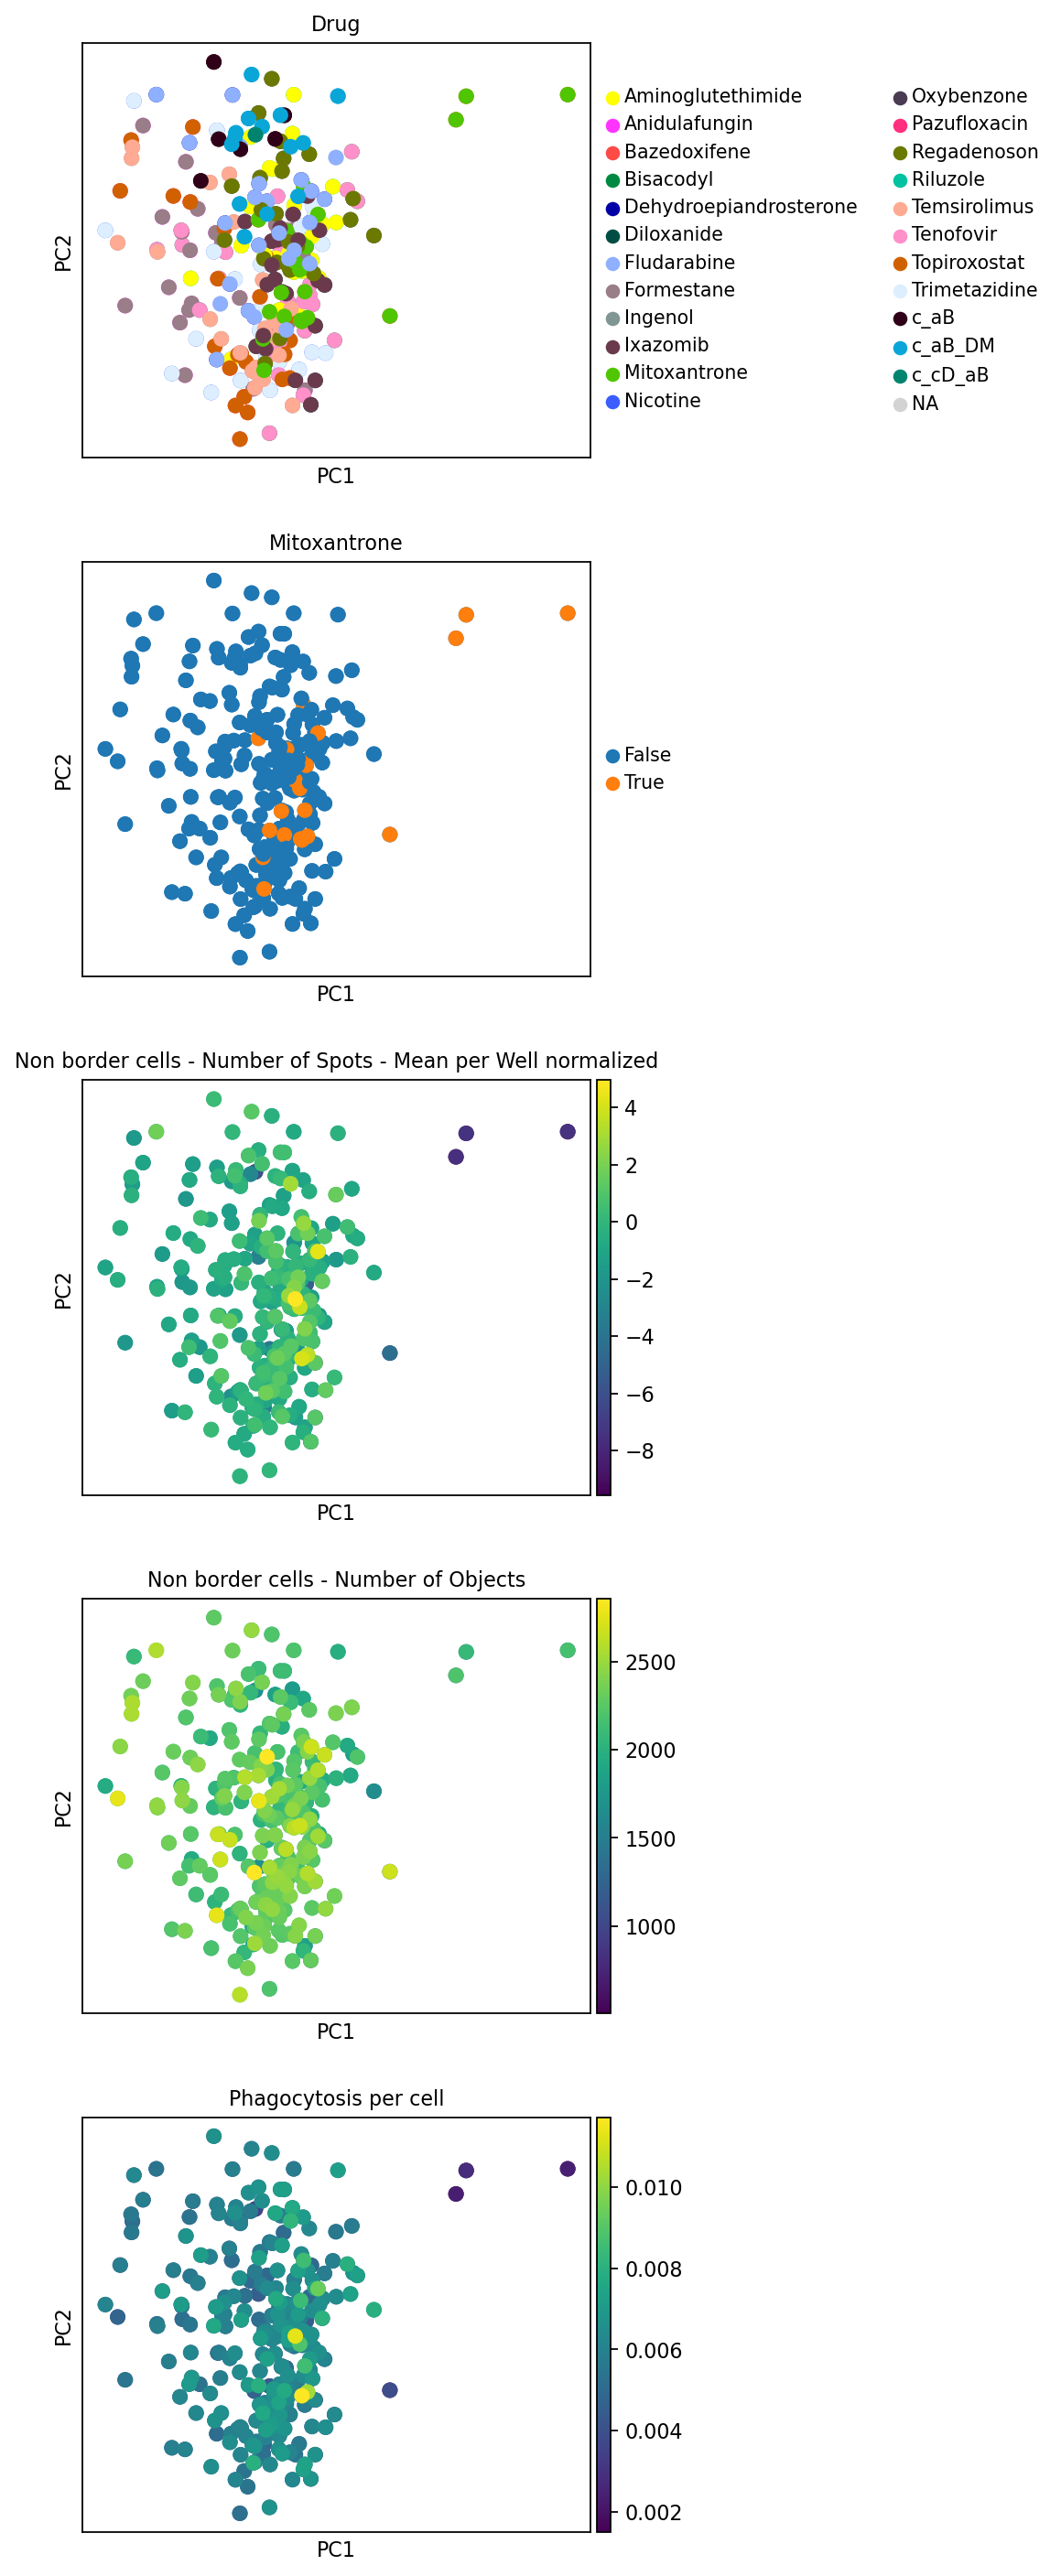

In [33]:
sc.pl.pca(adata0, color=[
        "Drug", "Mitoxantrone", phago_key, "Non border cells - Number of Objects", "Phagocytosis per cell",
    ], 
    ncols=1,
)

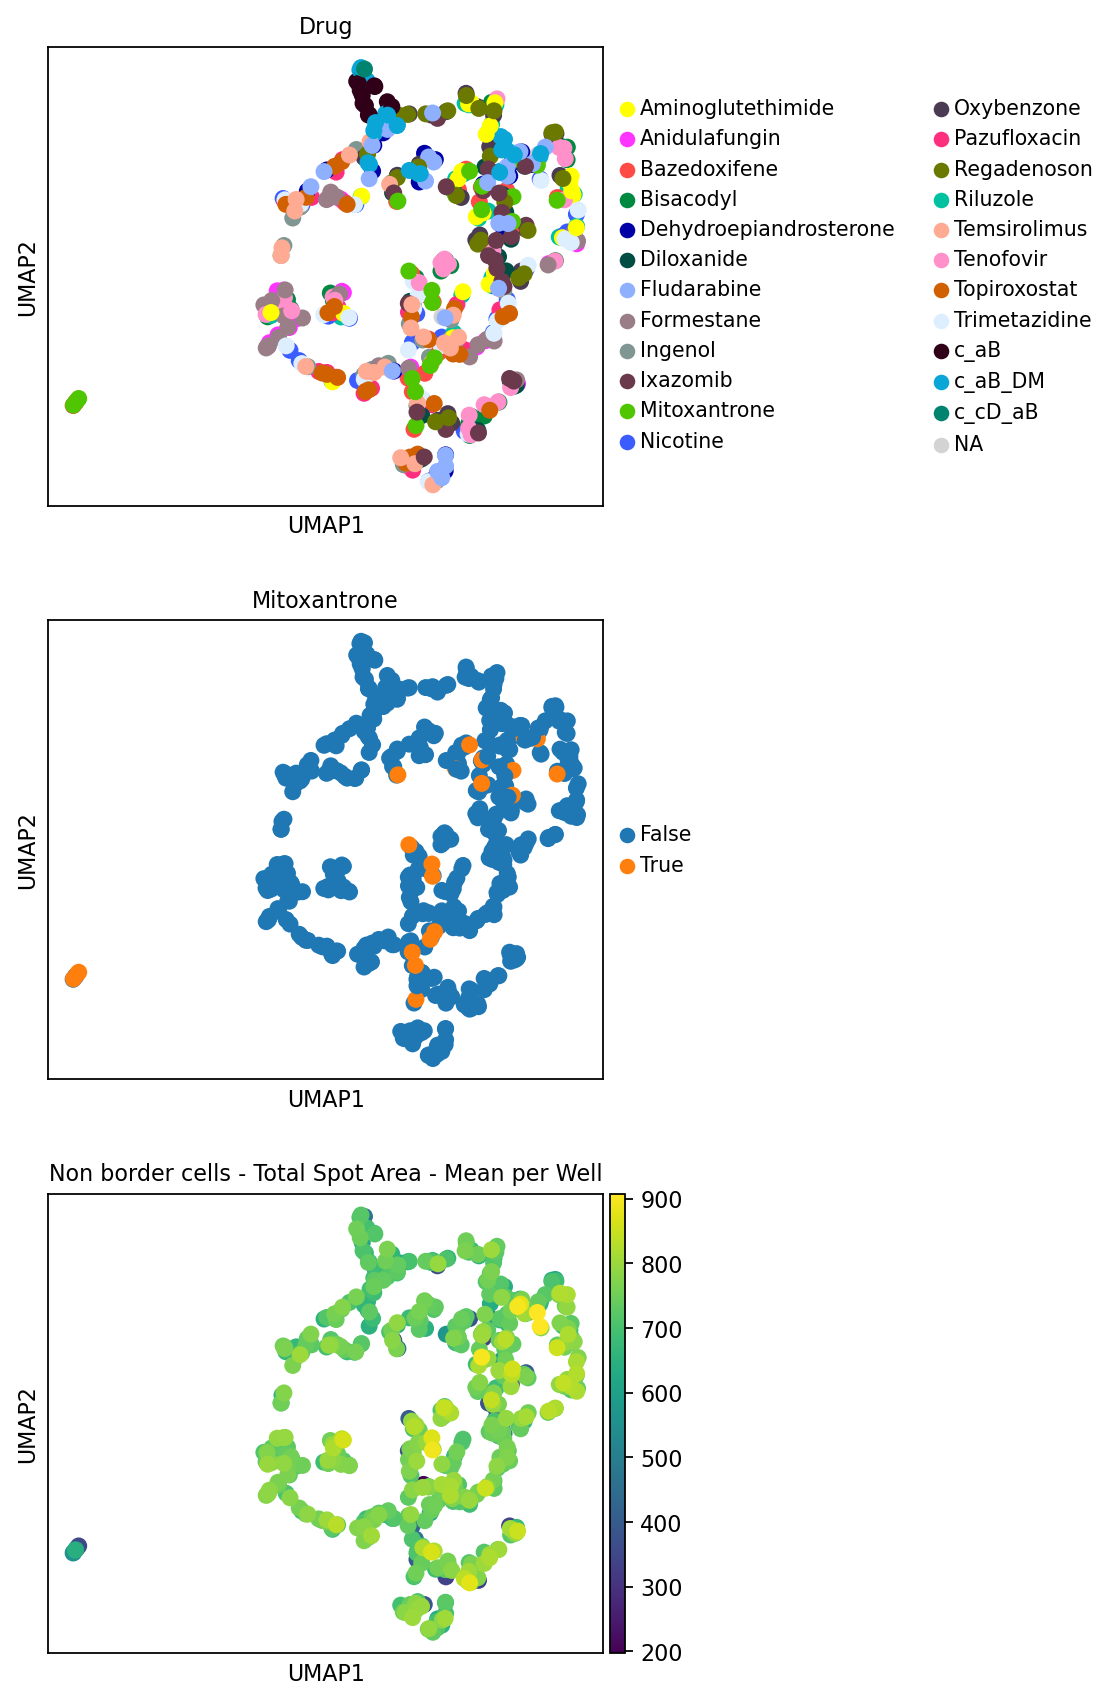

In [34]:
sc.pl.umap(adata0, color=["Drug", "Mitoxantrone", "Non border cells - Total Spot Area - Mean per Well"], ncols=1)